In [1]:
# %% Imports

import random
import csv

import numpy
import pandas
import tensorflow as tf
from keras import layers, utils, losses, metrics
import matplotlib.pyplot as pyplot
from tqdm import tqdm

from model import UNet, ClassifierNet

# Check for GPU
print(tf.config.list_physical_devices("GPU"))

WIDTH = 256
HEIGHT = 256
SIZE = (WIDTH, HEIGHT)
INPUTS_DIR = "datasets/validation/images/"
LABELS_DIR = "datasets/validation/segmentation/"
LABELS_FILE = "datasets/validation/classification.csv"
META_FILE = "datasets/validation/metadata.csv"
BATCH_SIZE = 1
SAVED_FILE = f"saved/p3/weights_{WIDTH}_{HEIGHT}.h5"

2023-12-08 01:21:52.056376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 01:21:52.056500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 01:21:52.108335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 01:21:52.218205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 01:21:53.683172: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-08 01:21:56.217856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:21:56.508011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:21:56.508086: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
target = pandas.read_csv(LABELS_FILE, header=0)
metadata = pandas.read_csv(META_FILE, header=0)
data_tb = pandas.merge(target, metadata, on="image_id")
data_tb['age_approximate'] = data_tb['age_approximate'].map(lambda x: float(x) if x != 'unknown' else -1.0)
data_tb['male'] = (data_tb['sex'] == 'male').astype(float)
data_tb['female'] = (data_tb['sex'] == 'female').astype(float)
data_tb['none'] = ((data_tb['melanoma'] < 0.5) & (data_tb['seborrheic_keratosis'] < 0.5)).astype(float)
metadata_tb = data_tb[['age_approximate', 'male', 'female']].to_numpy()
target_tb = data_tb[['none', 'melanoma', 'seborrheic_keratosis']].to_numpy()
images_tb = (INPUTS_DIR + data_tb['image_id'] + '.jpg').to_list()

In [3]:
def load_image(path):
    file = tf.io.read_file(path)
    image = tf.io.decode_image(file, channels=3, expand_animations=False)
    image = tf.image.resize(image, size=SIZE)
    return image

paths_ds = tf.data.Dataset.from_tensor_slices(images_tb)
inputs_ds = paths_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
metadata_ds = tf.data.Dataset.from_tensor_slices(metadata_tb).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()

2023-12-08 01:22:24.502799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:22:24.502893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:22:24.502935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:22:24.870549: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 01:22:24.870644: I external/local_xla/xla/stream_executor

In [4]:
model = ClassifierNet()
model((layers.Input((WIDTH, HEIGHT ,3)), layers.Input(3)))
model.load_weights(SAVED_FILE)

In [5]:
outputs_tb = numpy.ndarray((0, 2))
zipped = tf.data.Dataset.zip(inputs_ds, metadata_ds)
for inputs, metadata in zipped:
    outputs = model((inputs, metadata))
    outputs_tb = numpy.append(outputs_tb, outputs.numpy(), axis=0)

2023-12-08 01:22:31.738253: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-08 01:22:31.955661: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-08 01:22:31.955708: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2023-12-08 01:22:31.955810: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-08 01:22:32.821697: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-08 01:22:33.676623: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True, False],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True, False],
       [False,  True],
       [ Tr

In [42]:
input_image = tf.keras.utils.load_img("datasets/validation/images/ISIC_0013561.jpg", target_size=SIZE, color_mode="rgb")
inputs = tf.keras.utils.img_to_array(input_image)
meta = metadata[metadata.image_id == 'ISIC_0013561'].drop('image_id', axis=1).to_numpy()

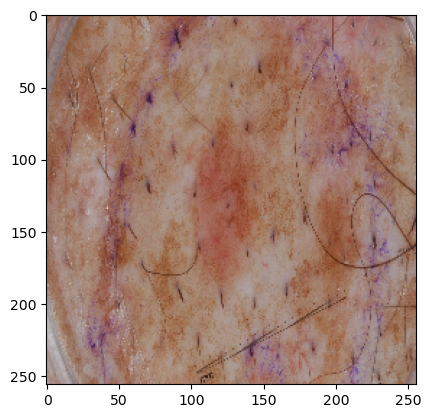

In [44]:
pyplot.imshow(input_image)

In [46]:
outputs = model((inputs.reshape((1, WIDTH, HEIGHT ,3)) / 255, meta))

2023-12-07 00:09:02.615180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


In [48]:
outputs

<tf.Tensor: shape=(), dtype=float32, numpy=0.2743316>